# Assignment 2 - Machine Learning
**Project:** Project 1 - Classify Images of Road Traffic Signs

**Group Name:** Dan & Ethan
| Name               | Student Number |
|--------------------|----------------|
| Daniel Schellekens | s3900792       |
| Ethan Rayner       | s3902240       |

In [1]:
IMAGES_FILE = "images.csv"
TEST_TRAIN_SPLIT = 0.5

from models.utils import prep_data

data, train_data, val_data = prep_data(IMAGES_FILE, TEST_TRAIN_SPLIT)
data.head()

Test set: 1849 rows
Validation set: 1850 rows


,path,shape,type
0,images\diamond\rightofway\00032_00000.png,diamond,rightofway
1,images\diamond\rightofway\00032_00001.png,diamond,rightofway
2,images\diamond\rightofway\00032_00002.png,diamond,rightofway
3,images\diamond\rightofway\00037_00000.png,diamond,rightofway
4,images\diamond\rightofway\00037_00001.png,diamond,rightofway


In [2]:
IMAGE_SIZE = 28
CLASS_COLUMN = "shape" 
BATCH_SIZE = 32

from models.utils import create_generators

train_generator, val_generator = create_generators(
    train_data, val_data, IMAGE_SIZE, CLASS_COLUMN, BATCH_SIZE)

Found 1849 validated image filenames belonging to 5 classes.
Found 1850 validated image filenames belonging to 5 classes.


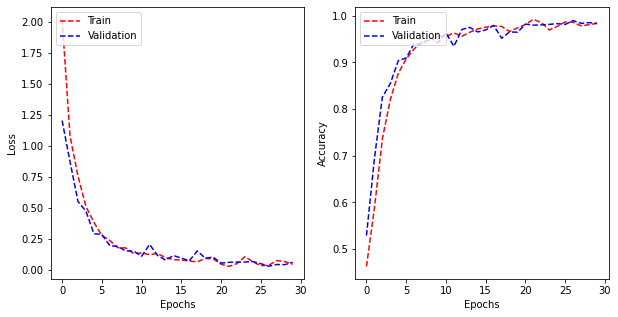

In [3]:
EPOCHS = 30

import models.vgg as vgg
from models.utils import plot_learning_curve

history = vgg.fit_model(data, CLASS_COLUMN, train_generator, val_generator, IMAGE_SIZE, EPOCHS)
plot_learning_curve(history)